# Generative Adversarial Network (GAN) 연습

<img src="./img/gan.png" width="100%">

## 필요한 모듈 import
* tensorflow (신경망 구성, 변수 설정, 역전파, gradient descent etc)
* numpy (텐서 연산)
* matplotlib (결과 그래프 출력)

In [14]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

## MNIST 데이터세트 로딩

In [15]:
# Import MNIST data
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("/tmp/data/", one_hot=True)

Extracting /tmp/data/train-images-idx3-ubyte.gz
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz


## 하이퍼 파라메터 설정
* hyper parameter는 사용자가 정의하는 변수들 
* learnable parameter는 학습을 통해 업데이트되는 변수들

In [16]:
# Training Parameters (hyper parameters)
num_steps = 70000
batch_size = 128
learning_rate = 0.0002

# Network Parameters (learnable parameters)
image_dim = 784 # 28*28 pixels
gen_hidden_dim = 256
dis_hidden_dim = 256
noise_dim = 100 # Noise data points

## Variable Initialization by Xavier

In [17]:
# A custom initialization (see Xavier Glorot init)
def glorot_init(shape):
    return tf.random_normal(shape=shape, stddev=1. / tf.sqrt(shape[0] / 2.))

## 러너블 파라메터 설정 (learnable parameter = network parameter)

In [18]:
# Store layers weight & bias

weights = {
    'gen_hidden': tf.Variable(glorot_init([noise_dim, gen_hidden_dim])),
    'gen_out': tf.Variable(glorot_init([gen_hidden_dim, image_dim])),
    'dis_hidden': tf.Variable(glorot_init([image_dim, dis_hidden_dim])),
    'dis_out': tf.Variable(glorot_init([dis_hidden_dim, 1])),
}

biases = {
    'gen_hidden': tf.Variable(tf.zeros([gen_hidden_dim])),
    'gen_out': tf.Variable(tf.zeros([image_dim])),
    'dis_hidden': tf.Variable(tf.zeros([dis_hidden_dim])),
    'dis_out': tf.Variable(tf.zeros([1])),
}

## Generator & Discriminator 모델 정의

<img src="./img/gan_generator.png" width="50%">
<img src="./img/gan_discriminator.png" width="50%">

In [21]:
# Generator
def generator(x):
    hidden_layer = tf.matmul(x, weights['gen_hidden'])
    hidden_layer = tf.add(hidden_layer, biases['gen_hidden'])
    hidden_layer = tf.nn.relu(hidden_layer)
    out_layer = tf.matmul(hidden_layer, weights['gen_out'])
    out_layer = tf.add(out_layer, biases['gen_out'])    
    out_layer = tf.nn.sigmoid(out_layer)
    return out_layer


# Discriminator
def discriminator(x):
    hidden_layer = tf.matmul(x, weights['dis_hidden'])
    hidden_layer = tf.add(hidden_layer, biases['dis_hidden'])    
    hidden_layer = tf.nn.relu(hidden_layer)
    out_layer = tf.matmul(hidden_layer, weights['dis_out'])
    out_layer = tf.add(out_layer, biases['dis_out'])    
    out_layer = tf.nn.sigmoid(out_layer)
    return out_layer

## Loss Function 정의 (Loss for Generator & Loss for Discriminator)

In [22]:

# Network Inputs
gen_input = tf.placeholder(tf.float32, shape=[None, noise_dim], name='input_noise')
dis_input = tf.placeholder(tf.float32, shape=[None, image_dim], name='dis_input')

# Build Generator Network
gen_sample = generator(gen_input)

# Build two Discriminator Networks (one from noise input, one from generated samples)
dis_real = discriminator(dis_input)
dis_fake = discriminator(gen_sample)

# Build Loss
gen_loss = -tf.reduce_mean(tf.log(dis_fake))
dis_loss = -tf.reduce_mean(tf.log(dis_real) + tf.log(1. - dis_fake))


## Gradient Descent & Back Propagation by optimizer

In [25]:
# Build Optimizers
optimizer_gen = tf.train.AdamOptimizer(learning_rate=learning_rate)
optimizer_dis = tf.train.AdamOptimizer(learning_rate=learning_rate)

# Training Variables for each optimizer
# By default in TensorFlow, all variables are updated by each optimizer, so we
# need to precise for each one of them the specific variables to update.

# Generator Network Variables
gen_vars = [weights['gen_hidden'], weights['gen_out'],
            biases['gen_hidden'], biases['gen_out']]

# Discriminator Network Variables
dis_vars = [weights['dis_hidden'], weights['dis_out'],
            biases['dis_hidden'], biases['dis_out']]

# Create training operations
train_gen = optimizer_gen.minimize(gen_loss, var_list=gen_vars)
train_dis = optimizer_dis.minimize(dis_loss, var_list=dis_vars)

## Start Training

In [27]:

# Start a new TF session
sess = tf.Session()

# Initialize the variables (i.e. assign their default value)
init = tf.global_variables_initializer()

# Run the initializer
sess.run(init)

# Training
for i in range(1, num_steps+1):
    # Prepare Data
    # Get the next batch of MNIST data (only images are needed, not labels)
    batch_x, _ = mnist.train.next_batch(batch_size)
    # Generate noise to feed to the generator
    z = np.random.uniform(-1., 1., size=[batch_size, noise_dim])

    # Train
    feed_dict = {dis_input: batch_x, gen_input: z}
    _, _, gl, dl = sess.run([train_gen, train_dis, gen_loss, dis_loss],
                            feed_dict=feed_dict)
    if i % 2000 == 0 or i == 1:
        print('Step %i: Generator Loss: %f, Discriminator Loss: %f' % (i, gl, dl))

Step 1: Generator Loss: 0.970180, Discriminator Loss: 1.138927
Step 2000: Generator Loss: 4.838144, Discriminator Loss: 0.033151
Step 4000: Generator Loss: 3.830829, Discriminator Loss: 0.095071
Step 6000: Generator Loss: 4.207316, Discriminator Loss: 0.090159
Step 8000: Generator Loss: 4.214020, Discriminator Loss: 0.106517
Step 10000: Generator Loss: 4.055887, Discriminator Loss: 0.149299
Step 12000: Generator Loss: 4.098374, Discriminator Loss: 0.126005
Step 14000: Generator Loss: 3.458981, Discriminator Loss: 0.324748
Step 16000: Generator Loss: 4.210803, Discriminator Loss: 0.277459
Step 18000: Generator Loss: 3.486015, Discriminator Loss: 0.316707
Step 20000: Generator Loss: 4.704051, Discriminator Loss: 0.209916
Step 22000: Generator Loss: 3.815471, Discriminator Loss: 0.248264
Step 24000: Generator Loss: 3.527544, Discriminator Loss: 0.306053
Step 26000: Generator Loss: 3.520978, Discriminator Loss: 0.256988
Step 28000: Generator Loss: 3.789693, Discriminator Loss: 0.206969
Ste

## Test 및 결과 비교

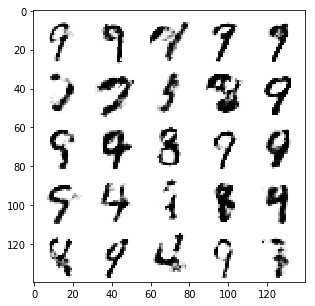

In [28]:
# Testing
# Generate images from noise, using the generator network.

n = 5
canvas = np.empty((28 * n, 28 * n))

for i in range(n):
    # Noise input.
    z = np.random.uniform(-1., 1., size=[n, noise_dim])
    
    # Generate image from noise.
    g = sess.run(gen_sample, feed_dict={gen_input: z})
    
    # Reverse colours for better display
    g = -1 * (g - 1)
    
    for j in range(n):
        # Draw the generated digits
        canvas[i * 28:(i + 1) * 28, j * 28:(j + 1) * 28] = g[j].reshape([28, 28])

plt.figure(figsize=(n, n))
plt.imshow(canvas, origin="upper", cmap="gray")
plt.show()